## Read concatatenated domain-average file and plot timeseries of variables

- Relevant information summarized on the [PINACES RCE website](https://portal.nersc.gov/cfs/m1867/pinacles_docs/site/fields_stats/)

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np


### some functions for convenience

In [2]:
def get_statgroup(varname):
    #list of groups in the domain-mean file    
    SurfaceVars = ['wind_horizontal','taux','tauy','tflx','qvflx','shf','lhf']
    VelocityStateVars = ['u','u_squared','u_min','u_max','v','v_squared','v_min','v_max',
                        'w','w_squared','w_min','w_max']
    ScalarStateVars = ['qv','qc','qnc','qr','qnr','qil','qnil','qir1','qib1','s']
    MicroBaseVars = ['CF','RF','LWP','RWP','VWP','RAINNC']
    DiagnosticsTurbulenceVars = ['tke_resolved','tke_sgs','u2','v2','w2','tke','thetali',
                                'qt','s2','qv2','thetali2','qt2','wqt','wthetali','wqv',
                                'wqc','wqnc','wqr','wqnr','wqi1','wqni1','wqir1','wqib1',
                                'ws']
    DiagnosticsCloudsVars = ['cloud_frac','core_frac','heating_rate_lw_cloud',
                            'heating_rate_lw_core','heating_rate_sw_cloud','heating_rate_sw_core']
    RRTMGVars = ['surface_sw_down','surface_sw_up','surface_lw_down','surface_lw_up',
                'toa_sw_down','toa_sw_up','toa_lw_down','toa_lw_up']
    
    igroup = ''
    if(not igroup) and (varname in SurfaceVars):
        igroup = 'Surface'
    if(not igroup) and (varname in VelocityStateVars):
        igroup = 'VelocityState'
    if(not igroup) and (varname in ScalarStateVars):
        igroup = 'ScalarState'
    if(not igroup) and (varname in MicroBaseVars):
        igroup = 'MicroBase'
    if(not igroup) and (varname in DiagnosticsTurbulenceVars):
        igroup = 'DiagnosticsTurbulence'
    if(not igroup) and (varname in DiagnosticsCloudsVars):
        igroup = 'DiagnosticsClouds'
    if(not igroup) and (varname in RRTMGVars):
        igroup = 'RRTMG'
        
    return igroup

In [3]:
def get_statvars(igroup):
    #list of variables within each group
    if(igroup == 'Surface'):
        varlist = ['wind_horizontal','taux','tauy','tflx','qvflx','shf','lhf']
        groupB = 'timeseries'
        
    elif(igroup == 'VelocityState'):
        varlist = ['u','u_squared','u_min','u_max','v','v_squared','v_min','v_max',
                        'w','w_squared','w_min','w_max']
        groupB = 'profiles'
        
    elif(igroup == 'ScalarState'):
        varlist = ['qv','qc','qnc','qr','qnr','qil','qnil','qir1','qib1','s']
        groupB = 'profiles'
        
    elif(igroup == 'MicroBase'):
        varlist = ['CF','RF','LWP','RWP','VWP','RAINNC']
        groupB = 'timeseries'
        
    elif(igroup == 'DiagnosticsTurbulence'):
        varlist = ['tke_resolved','tke_sgs','u2','v2','w2','tke','thetali',
                                'qt','s2','qv2','thetali2','qt2','wqt','wthetali','wqv',
                                'wqc','wqnc','wqr','wqnr','wqi1','wqni1','wqir1','wqib1',
                                'ws']
        groupB = 'profiles'
        
    elif(igroup == 'DiagnosticsClouds'):
        varlist = ['cloud_frac','core_frac','heating_rate_lw_cloud',
                            'heating_rate_lw_core','heating_rate_sw_cloud','heating_rate_sw_core']
        groupB = 'profiles'
    
    elif(igroup == 'RRTMG'):
        varlist = ['surface_sw_down','surface_sw_up','surface_lw_down','surface_lw_up',
                'toa_sw_down','toa_sw_up','toa_lw_down','toa_lw_up']
        groupB = 'timeseries'
        
    return varlist,groupB

#### get file paths and simulation name

In [5]:
figdir = '/pscratch/sd/w/wcmca1/PINACLES/rce/1km/archive/figs/stats'
indir = '/pscratch/sd/w/wcmca1/PINACLES/rce/1km/archive/stats'
infile = 'cat_stats_temp.nc'

icase = 'test_1km_01'

In [6]:
#load the basic domain information from the referene group in the file
reffile = 'stats_test_1km_01.nc' #using the output from the very first simulation
ds = xr.open_dataset((indir + '/' + reffile),group='reference')

z  = ds['z']
z_edge = ds['z_edge']
p0 = ds['P0']
P0_edge = ds['P0_edge']

ds.close()
del ds


### select variable group to plot
then go through all the variables under the selected group and plot them

In [8]:
groupA = 'Surface'
#each variable group has subgroups. Get a subgroup useful to be plotted as dictionary from the function
varlist,groupB = get_statvars(groupA)

In [9]:
#load the target group 
#use the specified group name and subgroup name obtained above; need them to form an xarray dataset
ds = xr.open_dataset((indir + '/' + infile),group=(groupA + '/' +groupB ))
time = ds['time']

#in case file concatenation was not done properly, sort the time variable
time = time.sortby('time') 

dtsec = 600
dt = np.timedelta64(dtsec, 's')

#convert the time array to pure numpy datetime64 arrays
offset_yr = np.timedelta64(30,'Y')
offset_yrinsec = offset_yr.astype('timedelta64[h]')
offset_hr = np.timedelta64(6,'h')
#the 6 days offset necessary to take care of leap years

nptime = time.to_numpy().astype('datetime64[s]') + offset_yrinsec - offset_hr #this change the year to 1970
nphour = nptime.astype('datetime64[h]')

ntime = len(time)

nhour = np.floor(ntime/(3600/dtsec))
nday =np.floor(nhour/24)

day = time/3600/24

In [10]:
Vars = {}
Units = {}
Lname = {}

for iv, invarname in enumerate(varlist):
    invar = ds[invarname]
    Vars[iv] = invar.sortby('time')

    try:
        Units[iv]  = invar.attrs['units']
    except KeyError:
        Units[iv] = ''

    try:
        Lname[iv]  = invar.attrs['long_name']
    except KeyError:
        Lname[iv] = invarname
    

In [11]:
### conveniene function to get y-axis limits for different variables

In [12]:
def get_ylim(varname):
    ymin = None
    ymax = None

    if(varname == 'toa_lw_up'):
        ymin = 240
        ymax = 300
    elif(varname == 'toa_sw_down'):
        ymin = 409
        ymax = 410
        
    
    ylims = [ymin, ymax]
    return ylims

In [13]:
#speficy the names of the variables to be plotted
#add some diagnostic variables not available as raw output as well (e.g., net radiation)
plotvarlist = varlist.copy()

if(groupA == 'RRTMG'):
    plotvarlist.append('toa_sw_net')
    plotvarlist.append('surface_sw_net')
    plotvarlist.append('toa_net')
    plotvarlist.append('surface_net')


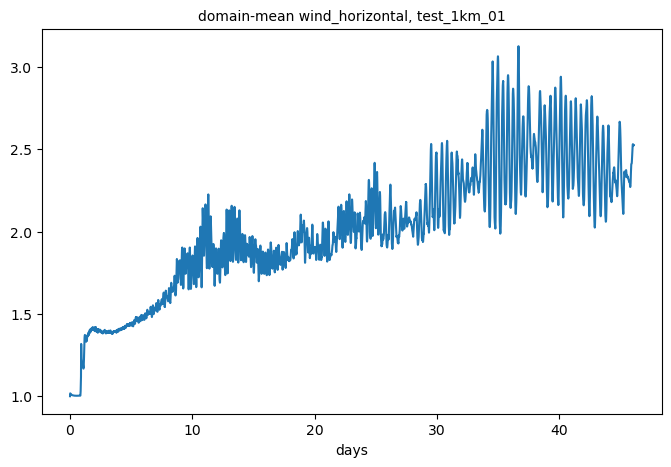

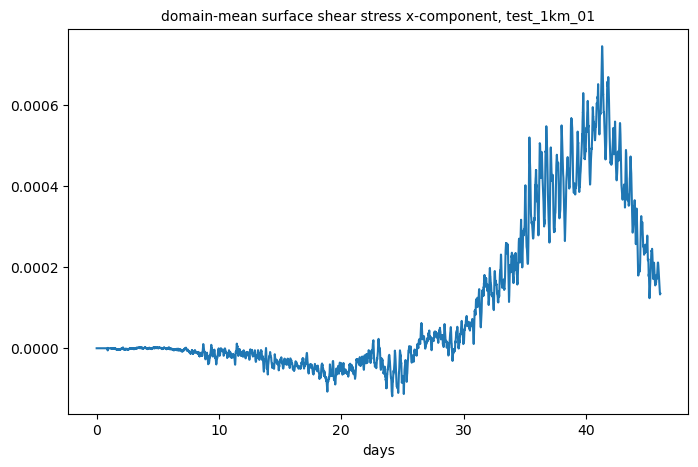

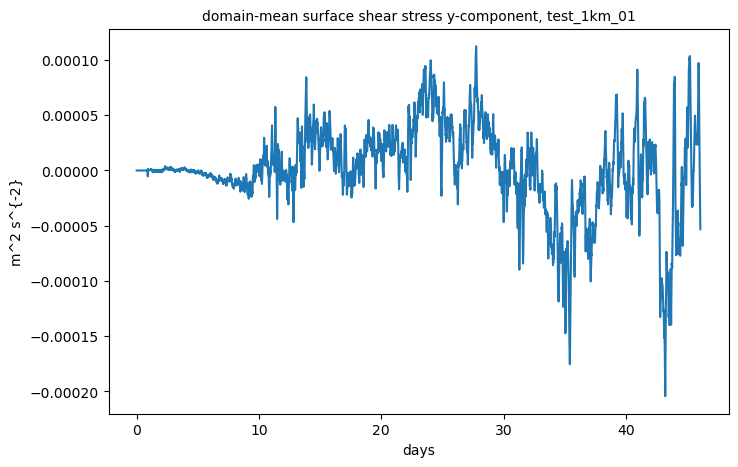

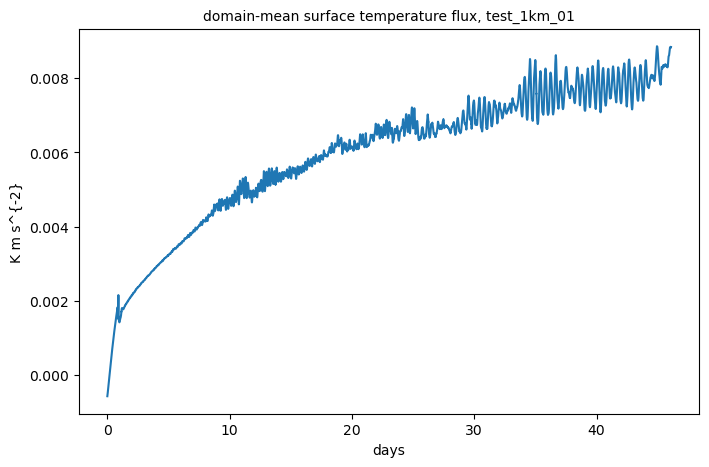

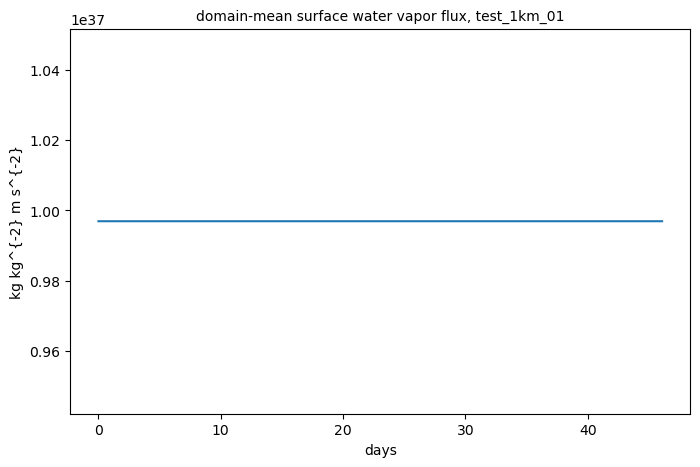

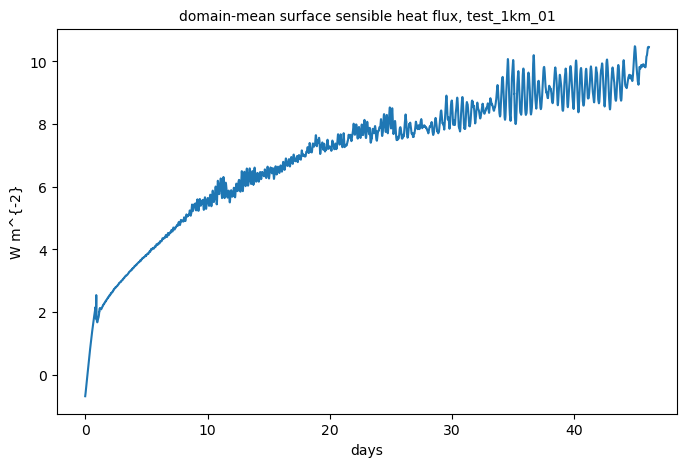

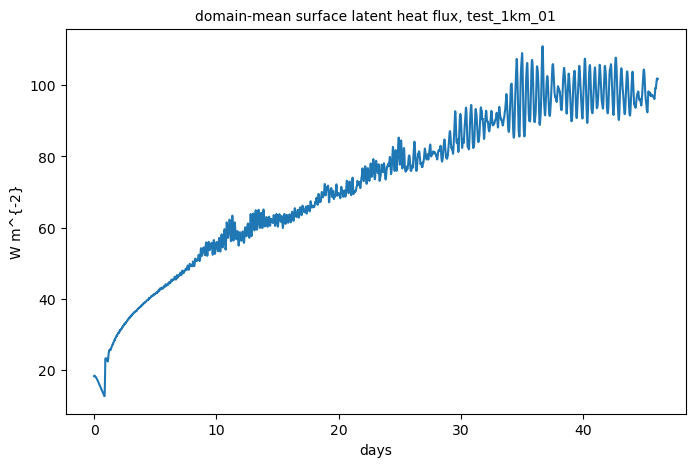

In [16]:
save_fig = False  

for iv, invarname in enumerate(plotvarlist):
    fig = plt.figure(figsize=(8,5))
    ax = plt.subplot(1,1,1)
    ylims = get_ylim(invarname)
    
    if(invarname == 'toa_sw_net'):
        inddown = varlist.index('toa_sw_down')
        indup = varlist.index('toa_sw_up')
        iplot = Vars[inddown] - Vars[indup]
        iunits = Units[indup]
        lname = 'TOA shortwave net'
    elif(invarname == 'surface_sw_net'):
        inddown = varlist.index('surface_sw_down')
        indup = varlist.index('surface_sw_up')
        iplot = Vars[inddown] - Vars[indup]
        iunits = Units[indup]
        lname = 'surface shortwave net'
    elif(invarname == 'toa_net'):
        indswdown = varlist.index('toa_sw_down')
        indswup = varlist.index('toa_sw_up')
        #indlwdown = varlist.index('toa_lw_down') =0
        indlwup = varlist.index('toa_lw_up')
        iplot = Vars[indswdown] - Vars[indswup] -  Vars[indlwup]
        iunits = Units[indswdown]
        lname = 'TOA net radiation'
    elif(invarname == 'surface_net'):
        indswdown = varlist.index('surface_sw_down')
        indswup = varlist.index('surface_sw_up')
        indlwdown = varlist.index('surface_lw_down')
        indlwup = varlist.index('surface_lw_up')
        iplot = Vars[indswdown] - Vars[indswup] + Vars[indlwdown] - Vars[indlwup]
        iunits = Units[indswdown]
        lname = 'surface net radiation'
    else:
        iplot = Vars[iv]
        iunits = Units[iv]
        lname = Lname[iv] 
        
    #_=ax.plot(nptime,iplot)
    iplot = iplot.sortby('time') #sort by time again
    _=ax.plot(day,iplot)
    _= ax.set_xlabel('days')
    _= ax.set_ylabel(iunits)
    _= ax.set_title(('domain-mean ' + lname + ', ' +icase), fontsize='medium')
    _= ax.set_ylim(ylims[0],ylims[1])

    figname = (figdir + '/timeseries_avg_' + invarname + '_' + icase + '.pdf') 

    if(save_fig):
        plt.savefig(figname, dpi=400, bbox_inches='tight')
        #plt.close(fig) #another option for not plotting interactively
        plt.show()
    else:
        plt.show()  

    fig.clear() #this does free memory: https://stackoverflow.com/a/55834853/20647995
    plt.close(fig)


In [15]:
ds.close()
del ds